In [236]:
# Generate data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
from plotnine import *
# import pytimetk as tk
import textwrap

import statsmodels.api as sm
from pygam import GAM, ExpectileGAM, s, l, f
from sklearn.preprocessing import LabelEncoder

In [ ]:
# !pip install pytimetk

In [223]:
def generate_data(num_points, price_range, quantity_range, median_quantity, average_elasticity, label):
    # Generate prices
    prices = np.linspace(price_range[0], price_range[1], num_points)

    # Generate quantities within the specified range
    quantities = np.random.uniform(quantity_range[0], quantity_range[1], num_points)

    # Generate prices with a negative correlation to quantities
    slope = (price_range[1] - price_range[0]) / (quantity_range[1] - quantity_range[0]) * average_elasticity
    intercept = np.median(prices) - slope * median_quantity
    prices = slope * quantities + intercept + np.random.normal(0, 1.5, num_points)

    # Ensure prices stay within the specified range
    prices = np.clip(prices, price_range[0], price_range[1])

    # Create a DataFrame with the corrected data
    data_corrected = pd.DataFrame({'price': prices, 'quantity': quantities, 'product': len(prices) * [label]})
    
    return data_corrected

data = pd.DataFrame()
mapper = {
    'Premium Case | iPhone 15 Pro': {
        'num_points': 140,
        'price_range': (40, 90),
        'quantity_range': (0, 573),
        'median_quantity': 220,
        'average_elasticity': -0.42
    },
    'Premium Case | iPhone 15 Pro Max': {
        'num_points': 147,
        'price_range': (30, 70),
        'quantity_range': (575, 1100),
        'median_quantity': 800,
        'average_elasticity': -0.429
    },
    'Standard Case | iPhone 15 Pro': {
        'num_points': 136,
        'price_range': (10, 50),
        'quantity_range': (0, 1253),
        'median_quantity': 350,
        'average_elasticity': -0.44
    },
    'Standard Case | iPhone 15 Pro Max': {
        'num_points': 145,
        'price_range': (5, 35),
        'quantity_range': (693, 1200),
        'median_quantity': 900,
        'average_elasticity': -0.40
    }
}


data = pd.DataFrame()
for p in mapper.keys():
    # Generate synthetic data
    np.random.seed(1)
    product = mapper[p]
    num_points = product['num_points']
    price_range = product['price_range']
    quantity_range = product['quantity_range']
    median_quantity = product['median_quantity']
    average_elasticity = product['average_elasticity']
    label = p
    temp = generate_data(num_points, price_range, quantity_range, median_quantity, average_elasticity, label)
    data = pd.concat([temp, data], ignore_index=True)
data['event'] = 'No Event'


outliers = {
    'Premium Case | iPhone 15 Pro': {
        'Black Friday': {
            'quantity': [690, 500, 480, 490, 402, 505, 470, 470, 410, 
                             370, 360, 360, 360, 310, 305, 263, 250, 243, 
                             248, 244, 196, 128, 128, 103],
            'price': [43, 43, 44, 45, 44, 50, 65, 70, 46, 66, 66, 54,
                          73, 56, 55, 96, 66, 71, 77, 90, 94, 73, 73, 82]
        },
        'Christmas': {
            'quantity': [477, 473, 472, 355, 265, 263, 253, 248, 245, 125, 120],
            'price': [48, 50, 58, 74, 80, 81, 82, 83, 81, 85, 87]
        },
        'New iPhone': {
            'quantity': [248, 250, 247, 245, 130, 195, 196, 193, 125, 65, 67, 80, 95, 105, 88, 80, 80, 102, 5, 6],
            'price': [39, 47, 48, 45, 52, 55, 56, 66, 64, 52, 55, 57, 58, 68, 71, 75, 76, 80, 77, 90]
        },
        'The Big Game': {
            'quantity': [490, 250, 250, 200, 143],
            'price': [42, 43, 72, 79, 83]
        }
    },
    'Premium Case | iPhone 15 Pro Max': {
        'Black Friday': {
            'quantity': [1473, 1472, 1453, 1452, 1300, 1321, 1315, 1272, 
                        1332, 1245, 1240, 1121, 1118, 1066, 1054, 1049, 
                        1022, 1005, 1000, 982, 972, 970, 820],
            'price': [33, 38, 43, 41, 33, 36, 37, 36, 43, 53, 
                    51, 40, 48, 51, 52, 58, 61, 63, 58, 54, 57, 62, 70]
        },
        'Christmas': {
            'quantity': [1131, 1128, 1118, 1008, 987, 975, 800, 794, 743],
            'price': [38, 35, 40, 55, 58, 80, 82, 82, 86]
        },
        'New iPhone': {
            'quantity': [568, 521, 523, 500, 473, 470, 468, 315, 317, 250, 215],
            'price': [41, 41, 45, 46, 48, 49, 50, 51, 53, 55, 56]
        },
        'The Big Game': {
            'quantity': [1138, 998, 996, 976, 804, 784, 766, 755, 748],
            'price': [40, 51, 52, 55, 58, 60, 61, 62, 61]
        }     
    },
    'Standard Case | iPhone 15 Pro': {
        'Black Friday': {
            'quantity': [1158, 1157, 1015, 802, 782, 788, 500, 501, 473, 474, 382, 340, 205, 210, 100, 50],
            'price': [21, 25, 23, 32, 23, 27, 25, 26, 38, 40, 45, 48, 30, 26, 46, 48]
        },
        'Christmas': {
            'quantity': [1205, 1180, 1170, 805, 600, 400, 400, 201, 184, 5],
            'price': [18, 10, 12, 21, 24, 25, 44, 41, 42, 44]
        },
        'New iPhone': {
            'quantity': [973, 782, 600, 589, 401, 400, 387, 257, 253, 254, 221, 219,
                         198, 187, 178, 175, 174, 169, 165, 120, 100, 75, 53, 75, 58, 89, 115],
            'price': [13, 15, 20, 19, 21, 23, 24, 20, 23, 25, 30, 35, 32, 33, 45, 42,
                      43, 44, 46, 47, 44, 48, 45, 41, 49, 46, 43]
        },
        'The Big Game': {
            'quantity': [885, 812, 601, 597, 583, 412, 400, 402, 382, 382, 400, 178, 170],
            'price': [18, 21, 21, 23, 30, 30, 27, 26, 22, 38, 40, 36, 34]
        } 
    },
    'Standard Case | iPhone 15 Pro Max': {
        'Black Friday': {
            'quantity': [1414, 1420, 1425, 1426, 1512, 1587, 1420, 1421, 1414, 1410, 1398, 1398, 1373, 1302, 1301, 1303, 1303, 1400, 1387],
            'price': [12, 13, 16, 18, 17, 12, 20, 21, 19, 20, 19, 30, 33, 24, 25, 29, 30, 28, 30]
        },
        'Christmas': {
            'quantity': [1251, 1253, 1309, 1368, 1200, 1195, 1118],
            'price': [9, 8, 11, 18, 19, 17, 9]
        },
        'New iPhone': {
            'quantity': [883, 881, 872, 778, 793, 781, 776, 753, 601, 598, 597, 596, 504, 507, 481, 405, 387, 205],
            'price': [11, 13, 15, 20, 21, 22, 21, 24, 22, 23, 23, 24, 24, 25, 26, 25, 26, 28]
        },
        'The Big Game': {
            'quantity': [1215, 1200, 1200, 1118, 1009, 1119, 1118, 1115, 857, 814],
            'price': [4, 5, 25, 20, 15, 25, 26, 27, 26, 32]
        }
    },
}

data_outliers = pd.DataFrame()
for k in outliers.keys():
    n = 0
    for m in outliers[k].keys():
        temp_data = outliers[k][m]
        temp = pd.DataFrame(temp_data)
        temp['event'] = [m] * temp.shape[0]
        temp['product'] = [k] * temp.shape[0]
        data_outliers = pd.concat([temp, data_outliers], ignore_index=True)
        n += temp.shape[0]
#     print(k, n)
    
data = pd.concat([data, data_outliers], ignore_index=True)

print(data.info())
data.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     800 non-null    float64
 1   quantity  800 non-null    float64
 2   product   800 non-null    object 
 3   event     800 non-null    object 
dtypes: float64(2), object(2)
memory usage: 25.1+ KB
None


count unique                            top freq        mean  \
price     800.0    NaN                            NaN  NaN    40.24623   
quantity  800.0    NaN                            NaN  NaN  664.306587   
product     800      4  Standard Case | iPhone 15 Pro  202         NaN   
event       800      5                       No Event  568         NaN   

                 std       min         25%        50%         75%     max  
price      19.177761       4.0   22.830786       41.0   55.281196    96.0  
quantity  376.548638  0.065537  347.362862  705.27489  973.070186  1587.0  
product          NaN       NaN         NaN        NaN         NaN     NaN  
event            NaN       NaN         NaN        NaN         NaN     NaN

In [224]:
# Data Preparation
data['is_event'] = (data['event'] != 'No Event').astype(int).astype(str)

data['revenue'] = data['price'] * data['quantity']

data

price     quantity                            product         event  \
0    19.537878   904.430156  Standard Case | iPhone 15 Pro Max      No Event   
1    15.744272  1058.204518  Standard Case | iPhone 15 Pro Max      No Event   
2    25.629427   693.057988  Standard Case | iPhone 15 Pro Max      No Event   
3    23.880027   846.282614  Standard Case | iPhone 15 Pro Max      No Event   
4    23.241792   767.405237  Standard Case | iPhone 15 Pro Max      No Event   
..         ...          ...                                ...           ...   
795  90.000000   244.000000       Premium Case | iPhone 15 Pro  Black Friday   
796  94.000000   196.000000       Premium Case | iPhone 15 Pro  Black Friday   
797  73.000000   128.000000       Premium Case | iPhone 15 Pro  Black Friday   
798  73.000000   128.000000       Premium Case | iPhone 15 Pro  Black Friday   
799  82.000000   103.000000       Premium Case | iPhone 15 Pro  Black Friday   

    is_event       revenue  
0          0  17670.646214  
1          0  16660.659700  
2          0  17762.679177  
3          0  20209.251641  
4          0  17835.873121  
..       ...           ...  
795        1  21960.000000  
796        1  18424.000000  
797        1   9344.000000  
798        1   9344.000000  
799        1   8446.000000  

[800 rows x 6 columns]

In [226]:
# Product Analysis
fig = px.scatter(
    data,
    x='price',
    y='quantity',
    color='product',
    opacity=0.6,
    trendline='lowess',
    trendline_color_override ='blue',
    template='none',
    title='Product Sales: Price vs Quantity Analysis',
    width=800,
    height=600,)\
.update_traces(
    marker=dict(size=7),
    hoverlabel=dict(font=dict(size=10)),
    )\
.update_layout(
    legend_title_text='Product',
    title_font=dict(size=16),
    legend_font=dict(size=10),
    )\
.update_xaxes(
    title_text='Price',
    title_font=dict(size=10),
    tickfont=dict(size=10),
    )\
.update_yaxes(
    title_text='Quantity Sold',
    title_font=dict(size=10),
    tickfont=dict(size=10),
)

fig.show()

In [228]:
# Event Analysis

fig = px.scatter(
    data,
    x='price',
    y='quantity',
    color='event',
    facet_col='product',
    facet_col_wrap=2,
    facet_col_spacing=0.1,
    facet_row_spacing=0.1,
    opacity=0.6,
    trendline='lowess',
    trendline_color_override='blue',
    template='none',
    title='Product Sales: Event Analysis',
    width=800,
    height=700,
)\
.update_traces(
    marker=dict(size=7),
    hoverlabel=dict(font=dict(size=10)),
)\
.update_layout(
    legend_title_text='Product',
    title_font=dict(size=16),
    legend_font=dict(size=10),
)\
.update_xaxes(
    title_text='Price',
    title_font=dict(size=10),
    tickfont=dict(size=10),
    matches=None,
)\
.update_yaxes(
    title_text='Quantity Sold',
    title_font=dict(size=10),
    tickfont=dict(size=10),
    matches=None,
)

for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=10)

fig.for_each_xaxis(lambda axis: axis.update(showticklabels=True))
fig.for_each_yaxis(lambda axis: axis.update(showticklabels=True))

fig.show()

In [234]:
# Modeling Event Impact

df_encoded = data.copy()
df_encoded = pd.get_dummies(df_encoded, columns=['event', 'product'], 
                            drop_first=False)

colnames_event = df_encoded.columns[df_encoded.columns.str.startswith('event')]\
                    .tolist()

df_encoded[colnames_event] = df_encoded[colnames_event].astype(int)

colnames_product = df_encoded.columns[df_encoded.columns.str.startswith('product')]\
                    .tolist()

df_encoded[colnames_product] = df_encoded[colnames_product].astype(int)

df_encoded

price     quantity is_event       revenue  event_Black Friday  \
0    19.537878   904.430156        0  17670.646214                   0   
1    15.744272  1058.204518        0  16660.659700                   0   
2    25.629427   693.057988        0  17762.679177                   0   
3    23.880027   846.282614        0  20209.251641                   0   
4    23.241792   767.405237        0  17835.873121                   0   
..         ...          ...      ...           ...                 ...   
795  90.000000   244.000000        1  21960.000000                   1   
796  94.000000   196.000000        1  18424.000000                   1   
797  73.000000   128.000000        1   9344.000000                   1   
798  73.000000   128.000000        1   9344.000000                   1   
799  82.000000   103.000000        1   8446.000000                   1   

     event_Christmas  event_New iPhone  event_No Event  event_The Big Game  \
0                  0                 0               1                   0   
1                  0                 0               1                   0   
2                  0                 0               1                   0   
3                  0                 0               1                   0   
4                  0                 0               1                   0   
..               ...               ...             ...                 ...   
795                0                 0               0                   0   
796                0                 0               0                   0   
797                0                 0               0                   0   
798                0                 0               0                   0   
799                0                 0               0                   0   

     product_Premium Case | iPhone 15 Pro  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
..                                    ...   
795                                     1   
796                                     1   
797                                     1   
798                                     1   
799                                     1   

     product_Premium Case | iPhone 15 Pro Max  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   
..                                        ...   
795                                         0   
796                                         0   
797                                         0   
798                                         0   
799                                         0   

     product_Standard Case | iPhone 15 Pro  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
..                                     ...   
795                                      0   
796                                      0   
797                                      0   
798                                      0   
799                                      0   

     product_Standard Case | iPhone 15 Pro Max  
0                                            1  
1                                            1  
2                                            1  
3                                            1  
4                                            1  
..                                         ...  
795                                          0  
796                                          0  
797                                          0  
798       

In [237]:
X = df_encoded[['price'] + colnames_event + colnames_product]
X = sm.add_constant(X)
y = df_encoded['quantity']

model = sm.OLS(y, X).fit()

print(model.params)
model.summary()

const                                        1057.973663
price                                         -20.544194
event_Black Friday                            407.637916
event_Christmas                               365.567149
event_New iPhone                              -77.260553
event_No Event                                153.312832
event_The Big Game                            208.716319
product_Premium Case | iPhone 15 Pro          348.133920
product_Premium Case | iPhone 15 Pro Max      641.023465
product_Standard Case | iPhone 15 Pro         -80.714266
product_Standard Case | iPhone 15 Pro Max     149.530543
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               quantity   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     387.4
Date:                Tue, 28 May 2024   Prob (F-statistic):          1.27e-267
Time:                        13:54:12   Log-Likelihood:                -5242.3
No. Observations:                 800   AIC:                         1.050e+04
Df Residuals:                     791   BIC:                         1.054e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      1057.9737     22.927     46.145      0.000    1012.968    1102.979
price                                       -20.5442      0.757    -27.147      0.000     -22.030     -19.059
event_Black Friday                          407.6379     17.913     22.757      0.000     372.475     442.800
event_Christmas                             365.5671     25.099     14.565      0.000     316.299     414.836
event_New iPhone                            -77.2606     18.547     -4.166      0.000    -113.669     -40.853
event_No Event                              153.3128     10.489     14.616      0.000     132.723     173.902
event_The Big Game                          208.7163     24.648      8.468      0.000     160.333     257.099
product_Premium Case | iPhone 15 Pro        348.1339     25.305     13.758      0.000     298.461     397.807
product_Premium Case | iPhone 15 Pro Max    641.0235     16.737     38.300      0.000     608.169     673.878
product_Standard Case | iPhone 15 Pro       -80.7143     11.185     -7.216      0.000    -102.670     -58.758
product_Standard Case | iPhone 15 Pro Max   149.5305     14.709     10.166      0.000     120.657     178.404
==============================================================================
Omnibus:                       22.528   Durbin-Watson:                   1.462
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.085
Skew:                           0.059   Prob(JB):                     2.19e-11
Kurtosis:                       4.208   Cond. No.                     3.88e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.06e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [241]:
params_df = pd.DataFrame(model.params).T

np.log(
    (params_df['event_Black Friday'] + params_df['const']) / (params_df['event_No Event'] + params_df['const'])
)

0    0.19059
dtype: float64

In [250]:
# General Price Optimization: GAM
# 
# PROBLEM: Prices ar non-linear
# SOLUTION: the GAMs (Generalized ADditive Models)
# NOTES:
# - GAMs are like Linear Regression, but allow for non-linear relationship
# - NOT as useful for incorporating events

data_filtered = data.query('event == "No Event"')

unique_products = data_filtered['product'].unique()

all_gam_results = pd.DataFrame()

for product in unique_products:
    product_data = data_filtered[data_filtered['product'] == product]
    X = product_data[['price']]
    y = product_data['quantity']
    
    quantiles = [0.025, 0.5, 0.975]
    gam_results = {}
    
    # Fit the GAM model
    for q in quantiles:
        gam = ExpectileGAM(s(0), expectile=q)
        gam.fit(X, y)
        gam_results[f'pred_{q}'] = gam.predict(X)

    predictions_gam = pd.DataFrame(gam_results).set_index(X.index)
    
    predictions_gam_df = pd.concat([product_data[['price', 'product', 'quantity']],
                                   predictions_gam], axis=1)
    all_gam_results = pd.concat([all_gam_results, predictions_gam_df])

all_gam_results

price                            product     quantity   pred_0.025  \
0    19.537878  Standard Case | iPhone 15 Pro Max   904.430156   832.789867   
1    15.744272  Standard Case | iPhone 15 Pro Max  1058.204518  1020.997664   
2    25.629427  Standard Case | iPhone 15 Pro Max   693.057988   699.988120   
3    23.880027  Standard Case | iPhone 15 Pro Max   846.282614   713.763625   
4    23.241792  Standard Case | iPhone 15 Pro Max   767.405237   721.671555   
..         ...                                ...          ...          ...   
563  69.407912       Premium Case | iPhone 15 Pro   133.494259    56.781587   
564  55.366298       Premium Case | iPhone 15 Pro   462.471277   431.779948   
565  64.451276       Premium Case | iPhone 15 Pro   222.244149   181.232223   
566  54.925611       Premium Case | iPhone 15 Pro   494.809483   442.032548   
567  55.278342       Premium Case | iPhone 15 Pro   428.100701   433.866459   

        pred_0.5   pred_0.975  
0     923.083469  1007.482986  
1    1084.988584  1143.794180  
2     727.142165   788.137112  
3     760.160363   826.394566  
4     778.311937   845.039713  
..           ...          ...  
563   101.668708   152.960235  
564   486.700032   534.463003  
565   238.709206   287.549802  
566   495.596631   540.419088  
567   488.575060   535.726047  

[568 rows x 6 columns]

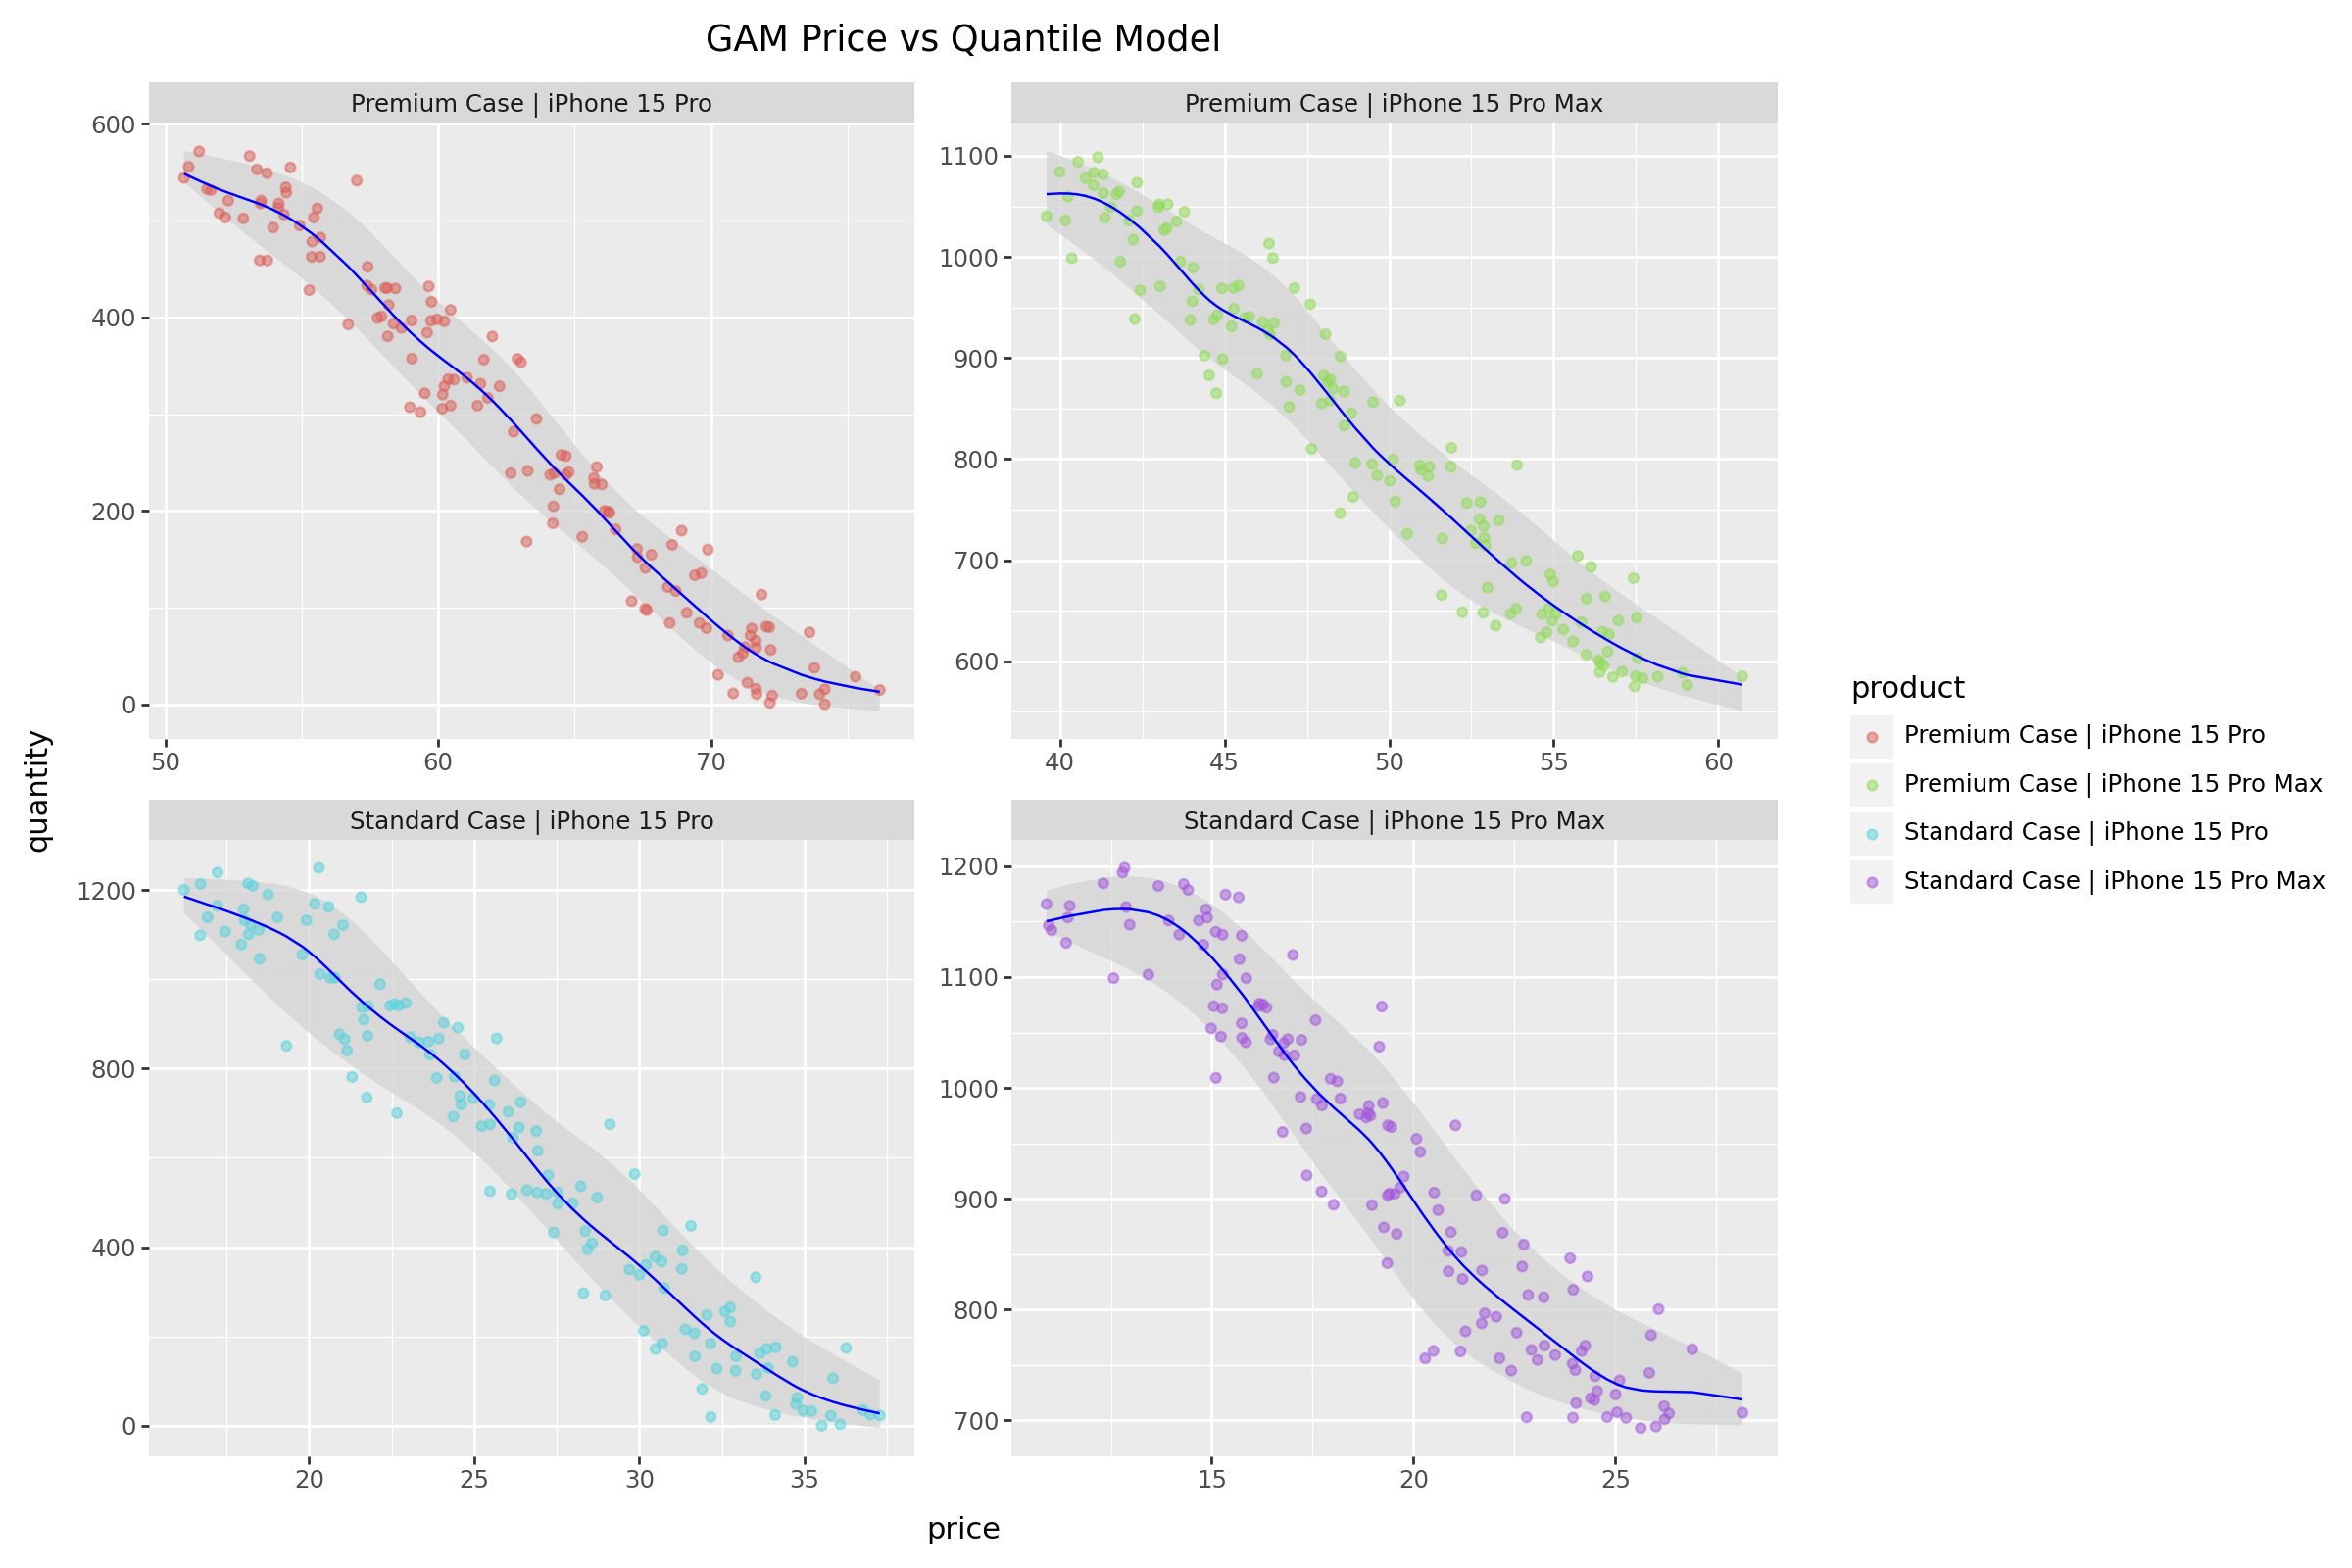

In [256]:
ggplot(
    data=all_gam_results,
    mapping=aes(x='price', y='quantity', color='product',
               group='product'),
) +\
geom_ribbon(aes(ymax="pred_0.975", ymin="pred_0.025"),
            fill='#d3d3d3', color='#FF000000',
            alpha=0.75, show_legend=False) +\
geom_point(alpha=0.5) +\
geom_line(aes(y='pred_0.5'), color='blue') +\
facet_wrap('product', scales='free') +\
labs(title="GAM Price vs Quantile Model") +\
theme(figure_size=(12, 8))

In [258]:
#  Optimize Price for Predicted Daily Revenue

for col in all_gam_results.columns:
    if col.startswith('pred'):
        all_gam_results['revenue_'+ col] = all_gam_results['price'] * all_gam_results[col]

all_gam_results['revenue_actual'] = all_gam_results['price'] * all_gam_results['quantity']
all_gam_results

price                            product     quantity   pred_0.025  \
0    19.537878  Standard Case | iPhone 15 Pro Max   904.430156   832.789867   
1    15.744272  Standard Case | iPhone 15 Pro Max  1058.204518  1020.997664   
2    25.629427  Standard Case | iPhone 15 Pro Max   693.057988   699.988120   
3    23.880027  Standard Case | iPhone 15 Pro Max   846.282614   713.763625   
4    23.241792  Standard Case | iPhone 15 Pro Max   767.405237   721.671555   
..         ...                                ...          ...          ...   
563  69.407912       Premium Case | iPhone 15 Pro   133.494259    56.781587   
564  55.366298       Premium Case | iPhone 15 Pro   462.471277   431.779948   
565  64.451276       Premium Case | iPhone 15 Pro   222.244149   181.232223   
566  54.925611       Premium Case | iPhone 15 Pro   494.809483   442.032548   
567  55.278342       Premium Case | iPhone 15 Pro   428.100701   433.866459   

        pred_0.5   pred_0.975  revenue_pred_0.025  revenue_pred_0.5  \
0     923.083469  1007.482986        16270.946966      18035.092359   
1    1084.988584  1143.794180        16074.864876      17082.355319   
2     727.142165   788.137112        17940.294484      18636.237116   
3     760.160363   826.394566        17044.694602      18152.649964   
4     778.311937   845.039713        16772.940390      18089.364392   
..           ...          ...                 ...               ...   
563   101.668708   152.960235         3941.091411       7056.612777   
564   486.700032   534.463003        23906.057160      26946.778872   
565   238.709206   287.549802        11680.648082      15385.113002   
566   495.596631   540.419088        24278.907832      27220.947812   
567   488.575060   535.726047        23983.418550      27007.619322   

     revenue_pred_0.975  revenue_actual  
0          19684.079848    17670.646214  
1          18008.206603    16660.659700  
2          20199.502646    17762.679177  
3          19734.324501    20209.251641  
4          19640.237493    17835.873121  
..                  ...             ...  
563        10616.650543     9265.557803  
564        29591.237759    25605.322438  
565        18532.951710    14323.919041  
566        29682.848643    27177.713191  
567        29614.047699    23664.697015  

[568 rows x 10 columns]

In [267]:
# Get the maximum prediction in quantile 0.5 per product
best_50 = all_gam_results\
            .groupby('product')\
            .apply(lambda x: x[x['revenue_pred_0.5'] == x['revenue_pred_0.5'].max()].head(1))\
            .reset_index(level=0, drop=True)

best_975 = all_gam_results\
            .groupby('product')\
            .apply(lambda x: x[x['revenue_pred_0.975'] == x['revenue_pred_0.975'].max()].head(1))\
            .reset_index(level=0, drop=True)

best_025 = all_gam_results\
            .groupby('product')\
            .apply(lambda x: x[x['revenue_pred_0.025'] == x['revenue_pred_0.025'].max()].head(1))\
            .reset_index(level=0, drop=True)

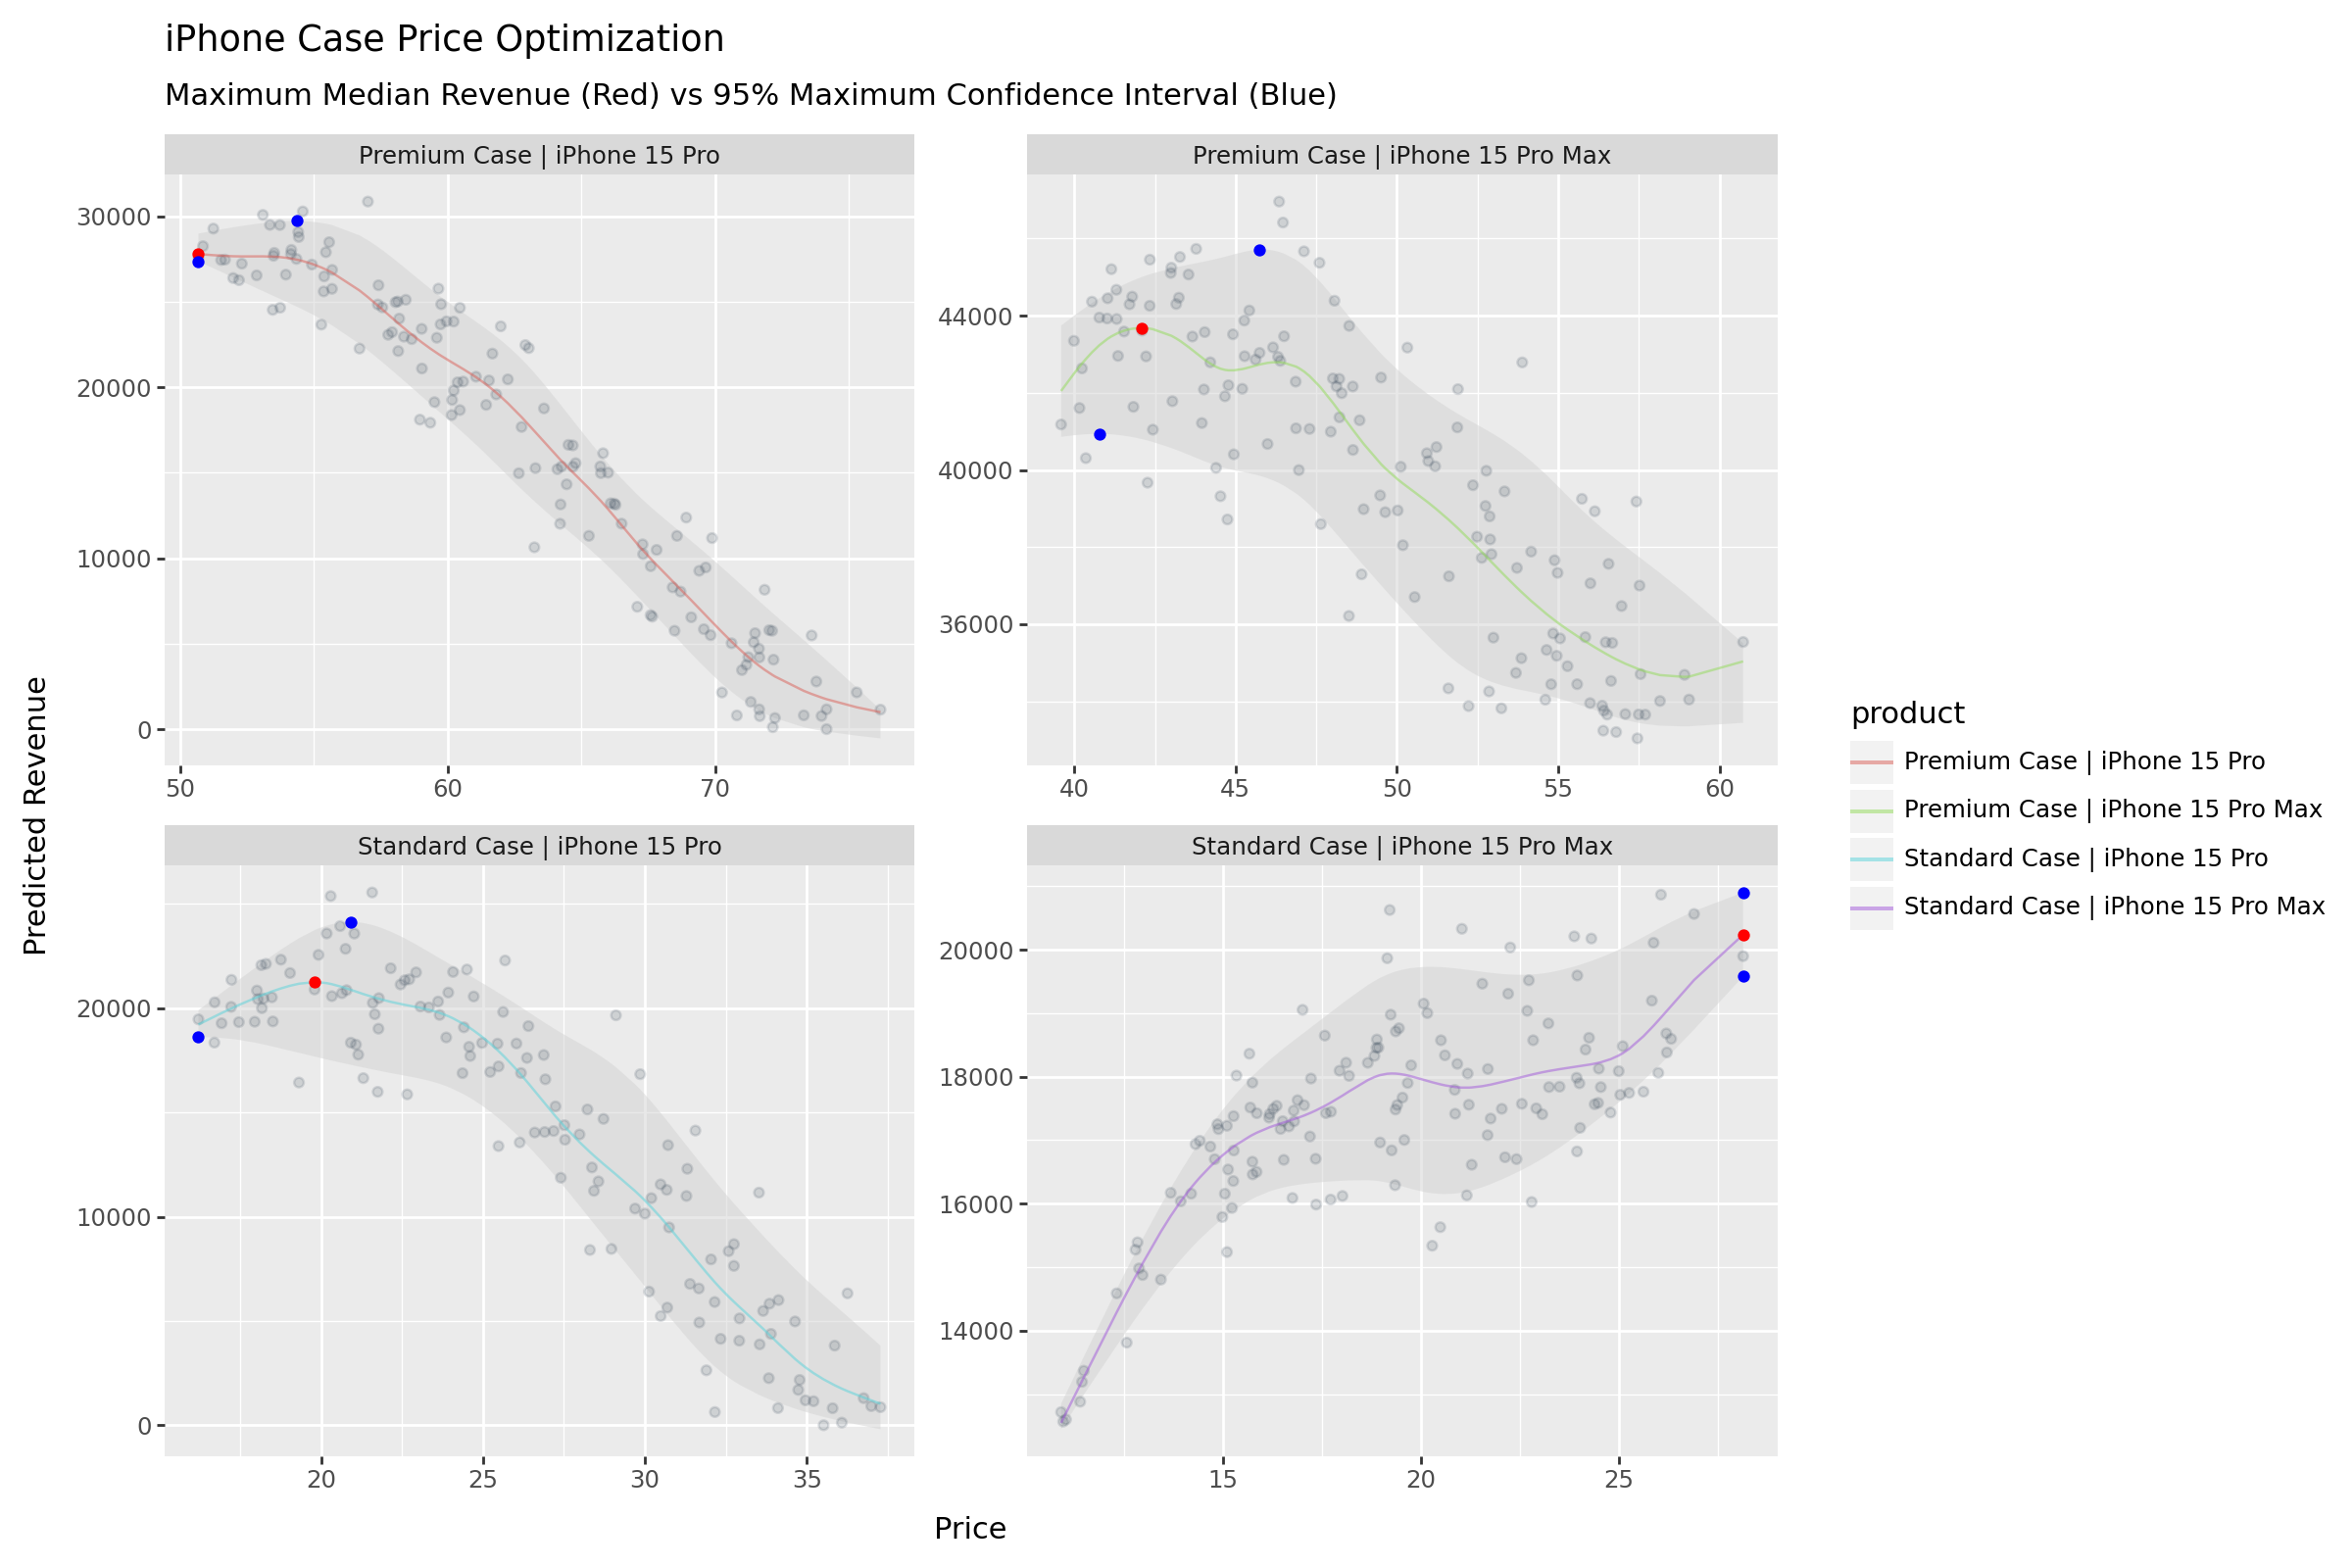

In [268]:
ggplot(
    data=all_gam_results,
    mapping=aes(x='price', y='revenue_pred_0.5', color='product', group='product'),
) +\
geom_ribbon(aes(ymax='revenue_pred_0.975', ymin='revenue_pred_0.025'),
            fill="#d3d3d3",
            color="#FF000000",
            alpha=0.5,
            show_legend=False)+\
geom_point(aes(y='revenue_actual'), alpha=0.15, color="#2C3E50") +\
geom_line(aes(y='revenue_pred_0.5'), alpha=0.5) +\
geom_point(data=best_50, color='red') +\
geom_point(data=best_975, mapping=aes(y = 'revenue_pred_0.975'), color='blue') +\
geom_point(data=best_025, mapping=aes(y = 'revenue_pred_0.025'), color='blue') +\
facet_wrap('product', scales='free')+\
labs(
    title='iPhone Case Price Optimization',
    subtitle = 'Maximum Median Revenue (Red) vs 95% Maximum Confidence Interval (Blue)',
    x = 'Price',
    y = 'Predicted Revenue'
) +\
theme(figure_size=(12, 8))

In [271]:
# MODELING GAMS WITH EVENTS
# 
# This is the case when there is event

data_filtered = data.query('event != "No Event"')

unique_products = data_filtered['product'].unique()

events_only_gam_results = pd.DataFrame()

for product in unique_products:
    product_event_data = data_filtered[(data_filtered['product'] == product)]
    
    if len(product_event_data) == 0:
        continue
    
    X = product_event_data[['price', 'event']]
    y = product_event_data['quantity']
    
    gam_results = {}
    
    le = LabelEncoder()
    X['event'] = le.fit_transform(X['event'])
    
    # use f(1) to indicate that the event columns is categorical
    gam = GAM(l(0) + f(1))
    
    gam.fit(X, y)
    gam_results[f'pred_0.5'] = gam.predict(X)
    
    predictions_gam = pd.DataFrame(gam_results).set_index(X.index)
    
    predictions_gam_df = pd.concat([product_event_data[['price',
                                                        'product',
                                                        'event',
                                                        'quantity']],
                                   predictions_gam],
                                  axis=1)
    
    events_only_gam_results = pd.concat([events_only_gam_results,
                                        predictions_gam_df], axis=0)

events_only_gam_results

C:\Users\Baha Tegar\AppData\Local\Temp\ipykernel_15768\3053051406.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Baha Tegar\AppData\Local\Temp\ipykernel_15768\3053051406.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Baha Tegar\AppData\Local\Temp\ipykernel_15768\3053051406.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

price                            product         event  quantity  \
568    4.0  Standard Case | iPhone 15 Pro Max  The Big Game    1215.0   
569    5.0  Standard Case | iPhone 15 Pro Max  The Big Game    1200.0   
570   25.0  Standard Case | iPhone 15 Pro Max  The Big Game    1200.0   
571   20.0  Standard Case | iPhone 15 Pro Max  The Big Game    1118.0   
572   15.0  Standard Case | iPhone 15 Pro Max  The Big Game    1009.0   
..     ...                                ...           ...       ...   
795   90.0       Premium Case | iPhone 15 Pro  Black Friday     244.0   
796   94.0       Premium Case | iPhone 15 Pro  Black Friday     196.0   
797   73.0       Premium Case | iPhone 15 Pro  Black Friday     128.0   
798   73.0       Premium Case | iPhone 15 Pro  Black Friday     128.0   
799   82.0       Premium Case | iPhone 15 Pro  Black Friday     103.0   

        pred_0.5  
568  1270.988238  
569  1259.189738  
570  1023.219738  
571  1082.212238  
572  1141.204738  
..           ...  
795   191.087535  
796   167.434526  
797   291.612826  
798   291.612826  
799   238.393554  

[232 rows x 5 columns]

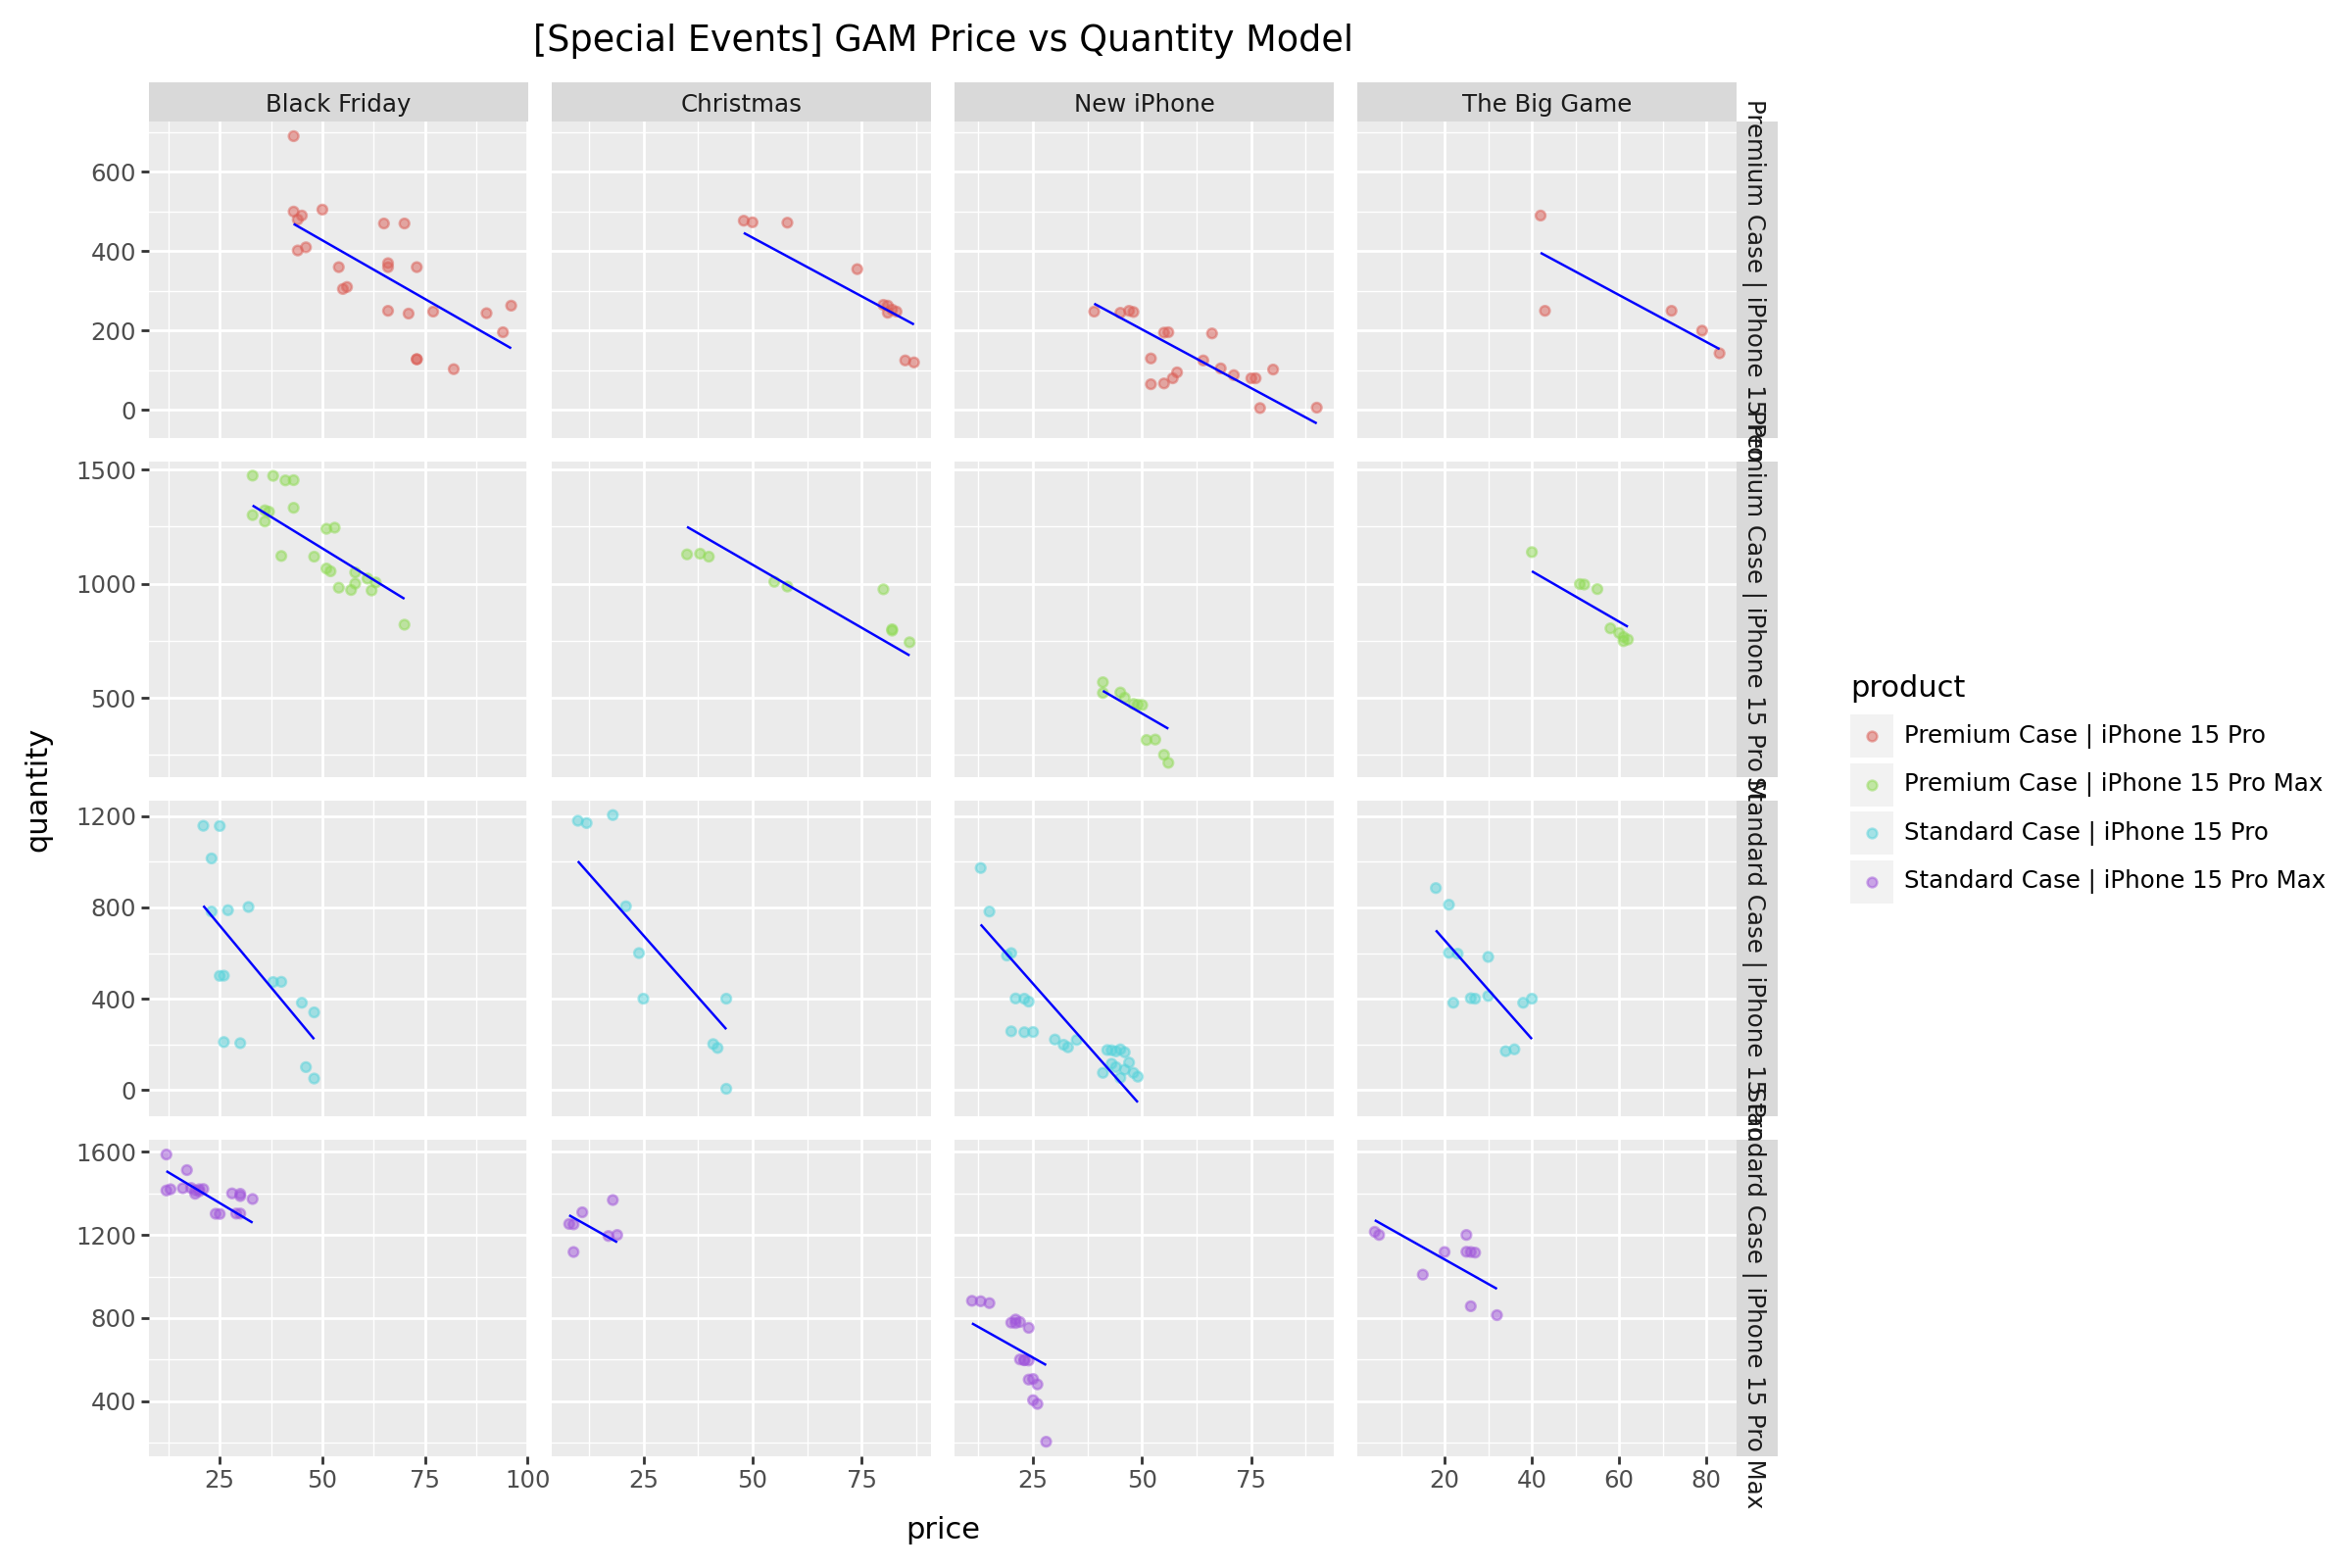

In [273]:
ggplot(
    data = events_only_gam_results,
    mapping= aes(x='price', y='quantity', color='product',)) +\
geom_point(alpha=.5) +\
geom_line(aes(y= 'pred_0.5'), color='blue')+\
facet_grid('product', 'event', scales='free')+\
labs(title="[Special Events] GAM Price vs Quantity Model")+\
theme(figure_size=(12, 8))

In [276]:
for col in events_only_gam_results.columns:
    if col.startswith('pred'):
        events_only_gam_results['revenue_' + col] =\
            events_only_gam_results['price'] + events_only_gam_results[col]

events_only_gam_results

price                            product         event  quantity  \
568    4.0  Standard Case | iPhone 15 Pro Max  The Big Game    1215.0   
569    5.0  Standard Case | iPhone 15 Pro Max  The Big Game    1200.0   
570   25.0  Standard Case | iPhone 15 Pro Max  The Big Game    1200.0   
571   20.0  Standard Case | iPhone 15 Pro Max  The Big Game    1118.0   
572   15.0  Standard Case | iPhone 15 Pro Max  The Big Game    1009.0   
..     ...                                ...           ...       ...   
795   90.0       Premium Case | iPhone 15 Pro  Black Friday     244.0   
796   94.0       Premium Case | iPhone 15 Pro  Black Friday     196.0   
797   73.0       Premium Case | iPhone 15 Pro  Black Friday     128.0   
798   73.0       Premium Case | iPhone 15 Pro  Black Friday     128.0   
799   82.0       Premium Case | iPhone 15 Pro  Black Friday     103.0   

        pred_0.5  revenue_pred_0.5  
568  1270.988238       1274.988238  
569  1259.189738       1264.189738  
570  1023.219738       1048.219738  
571  1082.212238       1102.212238  
572  1141.204738       1156.204738  
..           ...               ...  
795   191.087535        281.087535  
796   167.434526        261.434526  
797   291.612826        364.612826  
798   291.612826        364.612826  
799   238.393554        320.393554  

[232 rows x 6 columns]

In [277]:
best_50 = events_only_gam_results\
        .groupby(['product', 'event'])\
        .apply(lambda x: x[x['revenue_pred_0.5'] == x['revenue_pred_0.5'].max()].head(1))\
        .reset_index(level=0, drop=True)
best_50

price                            product         event  \
event                                                                      
Black Friday 776   43.0       Premium Case | iPhone 15 Pro  Black Friday   
Christmas    765   48.0       Premium Case | iPhone 15 Pro     Christmas   
New iPhone   745   39.0       Premium Case | iPhone 15 Pro    New iPhone   
The Big Game 740   42.0       Premium Case | iPhone 15 Pro  The Big Game   
Black Friday 717   33.0   Premium Case | iPhone 15 Pro Max  Black Friday   
Christmas    709   35.0   Premium Case | iPhone 15 Pro Max     Christmas   
New iPhone   697   41.0   Premium Case | iPhone 15 Pro Max    New iPhone   
The Big Game 688   40.0   Premium Case | iPhone 15 Pro Max  The Big Game   
Black Friday 672   21.0      Standard Case | iPhone 15 Pro  Black Friday   
Christmas    663   10.0      Standard Case | iPhone 15 Pro     Christmas   
New iPhone   635   13.0      Standard Case | iPhone 15 Pro    New iPhone   
The Big Game 622   18.0      Standard Case | iPhone 15 Pro  The Big Game   
Black Friday 603   12.0  Standard Case | iPhone 15 Pro Max  Black Friday   
Christmas    597    8.0  Standard Case | iPhone 15 Pro Max     Christmas   
New iPhone   578   11.0  Standard Case | iPhone 15 Pro Max    New iPhone   
The Big Game 568    4.0  Standard Case | iPhone 15 Pro Max  The Big Game   

                  quantity     pred_0.5  revenue_pred_0.5  
event                                                      
Black Friday 776     690.0   469.010397        512.010397  
Christmas    765     477.0   446.274242        494.274242  
New iPhone   745     248.0   267.959499        306.959499  
The Big Game 740     490.0   396.069556        438.069556  
Black Friday 717    1473.0  1342.115578       1375.115578  
Christmas    709    1128.0  1248.671455       1283.671455  
New iPhone   697     568.0   530.108657        571.108657  
The Big Game 688    1138.0  1054.110760       1094.110760  
Black Friday 672    1158.0   807.166563        828.166563  
Christmas    663    1180.0  1002.354152       1012.354152  
New iPhone   635     973.0   725.216882        738.216882  
The Big Game 622     885.0   699.578545        717.578545  
Black Friday 603    1414.0  1506.949389       1518.949389  
Christmas    597    1253.0  1294.651832       1302.651832  
New iPhone   578     883.0   774.724550        785.724550  
The Big Game 568    1215.0  1270.988238       1274.988238

In [278]:
def wrap_label(label, width=10):
    return '\n'.join(textwrap.wrap(label, width=width))